# Regression Deep Learning Model for [PROJECT NAME] Using Keras Version 5
### David Lowe
### January 14, 2020

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: The purpose of this project is to construct a predictive model using various machine learning algorithms and to document the end-to-end steps using a template. The [PROJECT NAME] dataset is a regression situation where we are trying to predict the value of a continuous variable.

INTRODUCTION: [Sample Paragraph - The purpose of the analysis is to predict the housing values in the suburbs of Boston by using the home sale transaction history.]

ANALYSIS: [Sample Paragraph - The baseline performance of the model achieved a root mean squared error (RMSE) of 5.06. After tuning the hyperparameters, the best model processed the training dataset with an RMSE of 4.72. Furthermore, the final model processed the test dataset with an RMSE of 3.03, which was even better than the baseline result from the training dataset.]

CONCLUSION: For this dataset, the model built using Keras and TensorFlow achieved a satisfactory result and should be considered for future modeling activities.

Dataset Used: [PROJECT NAME] Dataset

Dataset ML Model: Regression with numerical attributes

Dataset Reference: [https://raw.githubusercontent.com/jbrownlee/Datasets/master/housing.data]

One potential source of performance benchmarks: [https://machinelearningmastery.com/regression-tutorial-keras-deep-learning-library-python/]

Any deep-learning modeling project genrally can be broken down into about seven major tasks:

0. Prepare Environment
1. Load Data
2. Define Model
3. Fit and Evaluate Model
4. Optimize Model
5. Finalize Model

# Section 0. Prepare Environment

In [1]:
# Set the warning message filter
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
# Set the random seed number for reproducible results
seedNum = 888

In [3]:
# Load libraries and packages
import random
random.seed(seedNum)
import numpy as np
np.random.seed(seedNum)
import tensorflow as tf
tf.random.set_seed(seedNum)
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
import pandas as pd
import math
import os
import sys
import shutil
import urllib.request
import zipfile
import smtplib
import matplotlib.pyplot as plt
from datetime import datetime
from email.message import EmailMessage
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn import preprocessing

In [4]:
# Begin the timer for the script processing
startTimeScript = datetime.now()

# Set up the verbose flag to print detailed messages for debugging (setting to True will activate)
# verbose = True
# tf.debugging.set_log_device_placement(verbose)

# Set up the number of CPU cores available for multi-thread processing
n_jobs = -1
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
notifyStatus = False

# Set the number of folds for cross validation
n_folds = 5

# Set the flag for splitting the dataset
splitDataset = True
splitPercentage = 0.25

# Set various default Keras modeling parameters
default_loss = 'mean_squared_error'
default_optimizer = tf.optimizers.Adam(learning_rate=0.001)
default_kernel_init = tf.initializers.RandomNormal(seed=seedNum)
default_epoch = 100
default_batch = 32

Num GPUs Available:  0


In [5]:
# Set up the email notification function
def email_notify(msg_text):
    sender = os.environ.get('MAIL_SENDER')
    receiver = os.environ.get('MAIL_RECEIVER')
    gateway = os.environ.get('SMTP_GATEWAY')
    smtpuser = os.environ.get('SMTP_USERNAME')
    password = os.environ.get('SMTP_PASSWORD')
    if sender==None or receiver==None or gateway==None or smtpuser==None or password==None:
        sys.exit("Incomplete email setup info. Script Processing Aborted!!!")
    msg = EmailMessage()
    msg.set_content(msg_text)
    msg['Subject'] = 'Notification from Keras Regression Script'
    msg['From'] = sender
    msg['To'] = receiver
    server = smtplib.SMTP(gateway, 587)
    server.starttls()
    server.login(smtpuser, password)
    server.send_message(msg)
    server.quit()

In [6]:
# Reset the random number generators
def reset_random(x):
    random.seed(x)
    np.random.seed(x)
    tf.random.set_seed(x)

In [7]:
if (notifyStatus): email_notify("Phase 0 Prepare Environment completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Section 1. Load Data

In [8]:
if (notifyStatus): email_notify("Phase 1 Load Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## 1.a) Load Dataset

In [9]:
dataset_path = 'https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data'
# dest_file = os.path.basename(dataset_path)
# if (os.path.isfile(dest_file) == False) :
#     print('Downloading ' + dataset_path + ' as ' + dest_file)
#     with urllib.request.urlopen(dataset_path) as in_resp, open(dest_file, 'wb') as out_file:
#         shutil.copyfileobj(in_resp, out_file)
#     print(dest_file + 'downloaded!')
#     print('Unpacking ' + dest_file)
#     with zipfile.ZipFile(dest_file, 'r') as zip_ref:
#         zip_ref.extractall('.')
#     print(dest_file + 'unpacked!')

# inputFile = dest_file
# attrNames = ['attr' + str(i).zfill(2) for i in range(1,10)]
# colNames = ['id'] + attrNames + ['target']
colNames = ['CRIM','ZN','INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT','MEDV']
Xy_original = pd.read_csv(dataset_path, names=colNames, delim_whitespace=True, header=None)

# Take a peek at the dataframe after the import
Xy_original.head(10)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2
5,0.02985,0.0,2.18,0,0.458,6.430,58.7,6.0622,3,222.0,18.7,394.12,5.21,28.7
6,0.08829,12.5,7.87,0,0.524,6.012,66.6,5.5605,5,311.0,15.2,395.60,12.43,22.9
7,0.14455,12.5,7.87,0,0.524,6.172,96.1,5.9505,5,311.0,15.2,396.90,19.15,27.1
8,0.21124,12.5,7.87,0,0.524,5.631,100.0,6.0821,5,311.0,15.2,386.63,29.93,16.5
9,0.17004,12.5,7.87,0,0.524,6.004,85.9,6.5921,5,311.0,15.2,386.71,17.10,18.9


In [10]:
Xy_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
CRIM       506 non-null float64
ZN         506 non-null float64
INDUS      506 non-null float64
CHAS       506 non-null int64
NOX        506 non-null float64
RM         506 non-null float64
AGE        506 non-null float64
DIS        506 non-null float64
RAD        506 non-null int64
TAX        506 non-null float64
PTRATIO    506 non-null float64
B          506 non-null float64
LSTAT      506 non-null float64
MEDV       506 non-null float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB


In [11]:
Xy_original.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677082,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In [12]:
print(Xy_original.isnull().sum())
print('Total number of NaN in the dataframe: ', Xy_original.isnull().sum().sum())

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64
Total number of NaN in the dataframe:  0


## 1.b) Data Cleaning

In [13]:
# Standardize the class column to the name of targetVar if required
# Xy_original = Xy_original.rename(columns={'old_name': 'targetVar'})

# Dropping features
# Xy_original.drop(columns=['attribute_name'], inplace=True)

# Impute missing values
# Xy_original['col_name'].fillna('someValue', inplace=True)
# Xy_original['attribute_name'].fillna(value=Xy_original['attribute_name'].median(), inplace=True)

# Convert columns from one data type to another
# Xy_original.column_name = Xy_original.column_name.astype('int')
# Xy_original.column_name = Xy_original.column_name.astype('category')

# Convert features with Y/N levels into categorical feature of 1/0
# def reClassSomecol(target):
#     if (target == 'Y'): return 1
#     else: return 0
# Xy_original['targetVar'] = Xy_original['target'].apply(reClassSomecol)
# Xy_original.drop(columns=['target'], inplace=True)

# Take a peek at the dataframe after the cleaning
Xy_original.head(10)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2
5,0.02985,0.0,2.18,0,0.458,6.430,58.7,6.0622,3,222.0,18.7,394.12,5.21,28.7
6,0.08829,12.5,7.87,0,0.524,6.012,66.6,5.5605,5,311.0,15.2,395.60,12.43,22.9
7,0.14455,12.5,7.87,0,0.524,6.172,96.1,5.9505,5,311.0,15.2,396.90,19.15,27.1
8,0.21124,12.5,7.87,0,0.524,5.631,100.0,6.0821,5,311.0,15.2,386.63,29.93,16.5
9,0.17004,12.5,7.87,0,0.524,6.004,85.9,6.5921,5,311.0,15.2,386.71,17.10,18.9


In [14]:
Xy_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
CRIM       506 non-null float64
ZN         506 non-null float64
INDUS      506 non-null float64
CHAS       506 non-null int64
NOX        506 non-null float64
RM         506 non-null float64
AGE        506 non-null float64
DIS        506 non-null float64
RAD        506 non-null int64
TAX        506 non-null float64
PTRATIO    506 non-null float64
B          506 non-null float64
LSTAT      506 non-null float64
MEDV       506 non-null float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB


In [15]:
Xy_original.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677082,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In [16]:
print(Xy_original.isnull().sum())
print('Total number of NaN in the dataframe: ', Xy_original.isnull().sum().sum())

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64
Total number of NaN in the dataframe:  0


## 1.c) Feature Scaling and Pre-processing

In [17]:
# Use variable totCol to hold the number of columns in the dataframe
totCol = len(Xy_original.columns)

# Set up variable totAttr for the total number of attribute columns
totAttr = totCol-1

# targetCol variable indicates the column location of the target/class variable
# If the first column, set targetCol to 1. If the last column, set targetCol to totCol
# If (targetCol <> 1) and (targetCol <> totCol), be aware when slicing up the dataframes for visualization
targetCol = totCol

In [18]:
# We create attribute-only and target-only datasets (X_original and y_original)
# for various visualization and cleaning/transformation operations

if targetCol == totCol:
    X_original = Xy_original.iloc[:,0:totAttr]
    y_original = Xy_original.iloc[:,totAttr]
else:
    X_original = Xy_original.iloc[:,1:totCol]
    y_original = Xy_original.iloc[:,0]

print("Xy_original.shape: {} X_original.shape: {} y_original.shape: {}".format(Xy_original.shape, X_original.shape, y_original.shape))

Xy_original.shape: (506, 14) X_original.shape: (506, 13) y_original.shape: (506,)


In [19]:
# Set up the number of row and columns for visualization display. dispRow * dispCol should be >= totAttr
dispCol = 4
if totAttr % dispCol == 0 :
    dispRow = totAttr // dispCol
else :
    dispRow = (totAttr // dispCol) + 1
    
# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = dispCol*4
fig_size[1] = dispRow*4
plt.rcParams["figure.figsize"] = fig_size

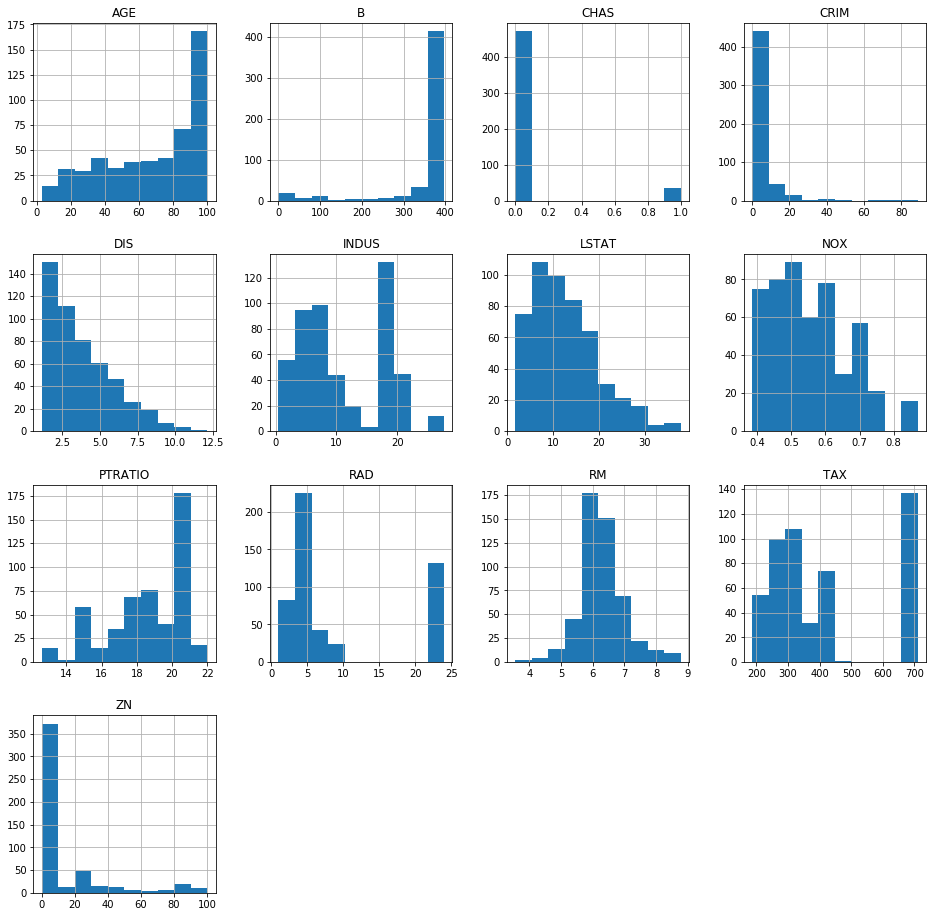

In [20]:
# Histograms for each attribute before pre-processing
X_original.hist(layout=(dispRow,dispCol))
plt.show()

In [21]:
tobe_transformed_cols = X_original.columns.tolist()
# tobe_transformed_cols.remove('some_column_label')
print(tobe_transformed_cols)

['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']


In [22]:
# Apply feature scaling and transformation
X_original = X_original.astype(float)
scaler = preprocessing.StandardScaler()
X_original[tobe_transformed_cols] = scaler.fit_transform(X_original[tobe_transformed_cols])

X_original.head(-10)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,-0.419782,0.284830,-1.287909,-0.272599,-0.144217,0.413672,-0.120013,0.140214,-0.982843,-0.666608,-1.459000,0.441052,-1.075562
1,-0.417339,-0.487722,-0.593381,-0.272599,-0.740262,0.194274,0.367166,0.557160,-0.867883,-0.987329,-0.303094,0.441052,-0.492439
2,-0.417342,-0.487722,-0.593381,-0.272599,-0.740262,1.282714,-0.265812,0.557160,-0.867883,-0.987329,-0.303094,0.396427,-1.208727
3,-0.416750,-0.487722,-1.306878,-0.272599,-0.835284,1.016303,-0.809889,1.077737,-0.752922,-1.106115,0.113032,0.416163,-1.361517
4,-0.412482,-0.487722,-1.306878,-0.272599,-0.835284,1.228577,-0.511180,1.077737,-0.752922,-1.106115,0.113032,0.441052,-1.026501
...,...,...,...,...,...,...,...,...,...,...,...,...,...
491,-0.408212,-0.487722,2.422565,-0.272599,0.469104,-0.429726,1.074822,-0.916009,-0.637962,1.798194,0.760340,0.366604,0.759313
492,-0.407563,-0.487722,2.422565,-0.272599,0.469104,-0.429726,0.530745,-0.801065,-0.637962,1.798194,0.760340,0.441052,0.097692
493,-0.400349,-0.487722,-0.211099,-0.272599,0.261784,-0.822932,-0.518292,-0.671859,-0.408041,-0.102376,0.344213,0.441052,-0.090141
494,-0.387983,-0.487722,-0.211099,-0.272599,0.261784,-0.510932,-0.923682,-0.671859,-0.408041,-0.102376,0.344213,0.441052,0.131334


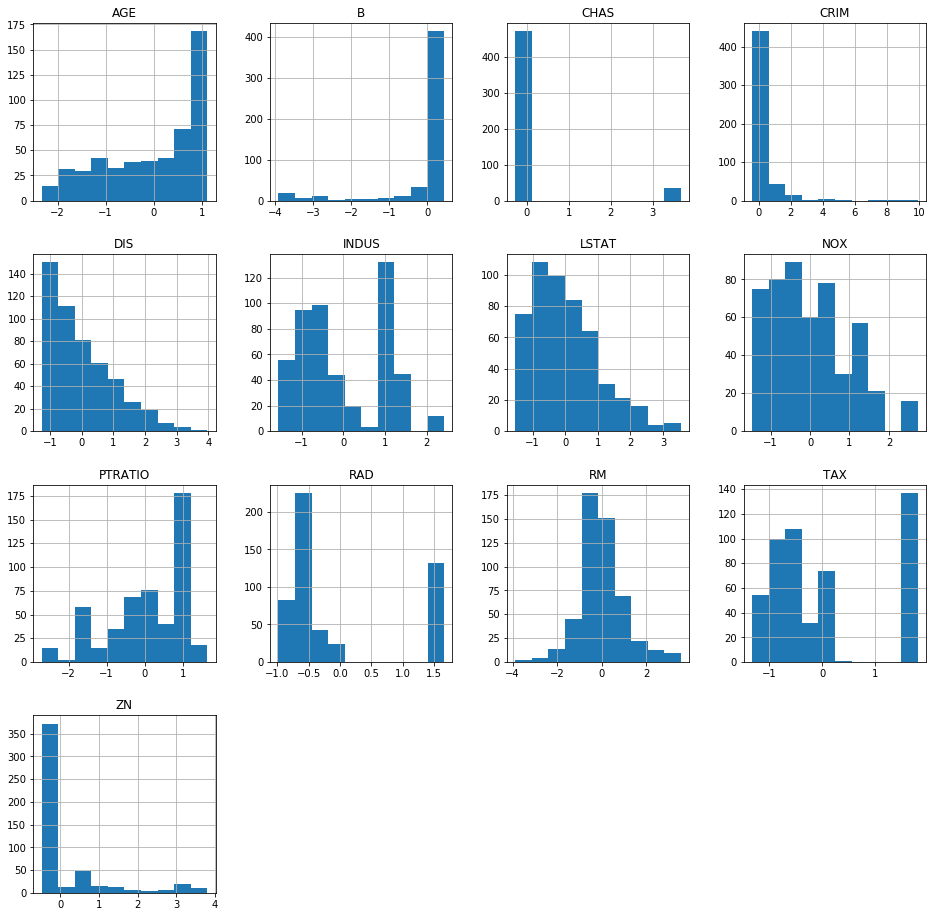

In [23]:
# Histograms for each attribute after pre-processing
X_original.hist(layout=(dispRow,dispCol))
plt.show()

In [24]:
# Perform one-hot-encoding before splitting into trainig and test
# X_original = pd.get_dummies(X_original)
# print(X_original.info())

## 1.d) Splitting Data into Training and Test Sets

In [25]:
X_encoded = X_original.to_numpy()
y_encoded = y_original.to_numpy()
if (splitDataset):
    X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=splitPercentage, random_state=seedNum)
else:
    X_train, y_train = X_encoded, y_encoded
    X_test, y_test = X_encoded, y_encoded
print("X_train.shape: {} X_train.type: {}".format(X_train.shape, type(X_train)))
print("y_train.shape: {} y_train.type: {}".format(y_train.shape, type(y_train)))
print("X_test.shape: {} X_test.type: {}".format(X_test.shape, type(X_test)))
print("y_test.shape: {} y_test.type: {}".format(y_test.shape, type(y_test)))

X_train.shape: (379, 13) X_train.type: <class 'numpy.ndarray'>
y_train.shape: (379,) y_train.type: <class 'numpy.ndarray'>
X_test.shape: (127, 13) X_test.type: <class 'numpy.ndarray'>
y_test.shape: (127,) y_test.type: <class 'numpy.ndarray'>


In [26]:
if (notifyStatus): email_notify("Phase 1 Load Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Section 2. Define Model

In [27]:
if (notifyStatus): email_notify("Phase 2 Define Model has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [28]:
# Define the Keras model required for KerasClassifier
def create_default_model():
    default_model = Sequential()
    default_model.add(Dense(25, input_shape=(13,), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(1, kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer)
    return default_model

In [29]:
if (notifyStatus): email_notify("Phase 2 Define Model completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Section 3. Fit and Evaluate Model

In [30]:
if (notifyStatus): email_notify("Phase 3 Fit and Evaluate Model has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [31]:
startTimeModule = datetime.now()

# Initialize the baseline model
reset_random(seedNum)
cv_model = KerasRegressor(build_fn=create_default_model, epochs=default_epoch, batch_size=default_batch, verbose=0)
# Fit and evaluate the Keras model using k-fold cross validation
kfold = KFold(n_splits=n_folds, shuffle=True, random_state=seedNum)
results = cross_val_score(cv_model, X_train, y_train, cv=kfold)
print('Generating results using the metrics of', default_loss)
print('All cross-Validate results:', results)
print('Baseline results [mean (std)]: %f (%f)' % (results.mean(), results.std()))
print('Average RMSE from all cv folds is:', math.sqrt(results.mean()*-1))
print('Total time for performing cross-validation of the default model:', (datetime.now() - startTimeModule))

Generating results using the metrics of mean_squared_error
All cross-Validate results: [-46.47742221 -15.92011236 -16.53179696 -28.05810125 -19.02766467]
Baseline results [mean (std)]: -25.203019 (11.491294)
Average RMSE from all cv folds is: 5.020260898574576
Total time for performing cross-validation of the default model: 0:00:20.074639


In [32]:
startTimeModule = datetime.now()

# Initialize the baseline model
reset_random(seedNum)
baseline_model = create_default_model()
baseline_hist = baseline_model.fit(X_train, y_train, epochs=default_epoch, batch_size=default_batch,
                                   validation_data=(X_test, y_test), verbose=1)
print('Total time for performing cross-validation of the default model:', (datetime.now() - startTimeModule))

Train on 379 samples, validate on 127 samples
Epoch 1/100
379/379 [==============================] - 1s 3ms/sample - loss: 581.6962 - val_loss: 579.3236
Epoch 2/100
379/379 [==============================] - 0s 208us/sample - loss: 545.9003 - val_loss: 517.5367
Epoch 3/100
379/379 [==============================] - 0s 173us/sample - loss: 472.0630 - val_loss: 422.3842
Epoch 4/100
379/379 [==============================] - 0s 145us/sample - loss: 375.6238 - val_loss: 313.9327
Epoch 5/100
379/379 [==============================] - 0s 174us/sample - loss: 278.0222 - val_loss: 217.2983
Epoch 6/100
379/379 [==============================] - 0s 184us/sample - loss: 198.5361 - val_loss: 149.5430
Epoch 7/100
379/379 [==============================] - 0s 168us/sample - loss: 143.0606 - val_loss: 108.7005
Epoch 8/100
379/379 [==============================] - 0s 161us/sample - loss: 109.1332 - val_loss: 84.0668
Epoch 9/100
379/379 [==============================] - 0s 170us/sample - loss: 87.209

In [33]:
# List all data points in the baseline model training history
print(baseline_hist.history.keys())

dict_keys(['loss', 'val_loss'])


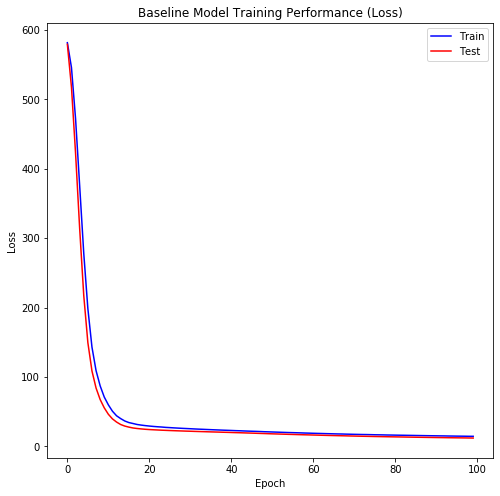

In [34]:
# Summarize model training hisotry for accuracy and loss
fig, axs = plt.subplots(1, 1, figsize=(8,8))
plt.subplot(111)
plt.plot(baseline_hist.history['loss'], color='blue', label='train')
plt.plot(baseline_hist.history['val_loss'], color='red', label='test')
plt.title('Baseline Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [35]:
if (notifyStatus): email_notify("Phase 3 Fit and Evaluate Model completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Section 4. Optimize Model

In [36]:
if (notifyStatus): email_notify("Phase 4 Optimize Model has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [37]:
# Define the Keras model required for KerasClassifier
def create_customized_model(optimizer, kernel_init):
    customized_model = Sequential()
    customized_model.add(Dense(25, input_shape=(13,), activation='relu', kernel_initializer=kernel_init))
    customized_model.add(Dense(1, kernel_initializer=kernel_init))
    customized_model.compile(loss=default_loss, optimizer=optimizer)
    return customized_model

In [38]:
# Perform model hyperparameter tuning via SciKit Learn's GridSearchCV
startTimeModule = datetime.now()

# Perform grid search using different epochs, batch sizes, and optimizers
optz_1 = tf.optimizers.Adam(learning_rate=0.0010)
optz_2 = tf.optimizers.Adam(learning_rate=0.0005)
optz_3 = tf.optimizers.Adam(learning_rate=0.0001)
optimizer_grid = [optz_1, optz_2, optz_3]
print('Optimizer candidate #1 has the object ID of', optz_1)
print('Optimizer candidate #2 has the object ID of', optz_2)
print('Optimizer candidate #3 has the object ID of', optz_3)

init_1 = tf.initializers.RandomNormal(seed=seedNum)
init_2 = tf.initializers.Orthogonal(seed=seedNum)
init_3 = tf.initializers.GlorotNormal(seed=seedNum)
init_grid = [init_1, init_2, init_3]
print('Initializer candidate #1 has the object ID of', init_1)
print('Initializer candidate #2 has the object ID of', init_2)
print('Initializer candidate #2 has the object ID of', init_3)

epoch_grid = [default_epoch]
batch_grid = [default_batch, int(default_batch*2), int(default_batch*4)]

# Create grid model
param_grid = dict(optimizer=optimizer_grid, kernel_init=init_grid, epochs=epoch_grid, batch_size=batch_grid)
reset_random(seedNum)
grid_model = KerasRegressor(build_fn=create_customized_model, verbose=0)
grid = GridSearchCV(estimator=grid_model, param_grid=param_grid, cv=n_folds, n_jobs=n_jobs, verbose=3)
# n_iter = int(len(optimizer_grid) * len(init_grid) * len(epoch_grid) * len(batch_grid) * 0.5)
# grid = RandomizedSearchCV(estimator=grid_model, param_distributions=param_grid, n_iter=n_iter, cv=n_folds, n_jobs=n_jobs, verbose=3)
grid_result = grid.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))
print('The best RMSE obtained from the models is:', math.sqrt(grid_result.best_score_*-1))
print('Total time for performing grid-search of the best parameters:', (datetime.now() - startTimeModule))

Optimizer candidate #1 has the object ID of <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f9128349dd0>
Optimizer candidate #2 has the object ID of <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f9128349d10>
Optimizer candidate #3 has the object ID of <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f9128349c50>
Initializer candidate #1 has the object ID of <tensorflow.python.ops.init_ops_v2.RandomNormal object at 0x7f9128349550>
Initializer candidate #2 has the object ID of <tensorflow.python.ops.init_ops_v2.Orthogonal object at 0x7f912836c910>
Initializer candidate #2 has the object ID of <tensorflow.python.ops.init_ops_v2.GlorotNormal object at 0x7f912836c250>
Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:  1.5min finished
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best: -27.176924 using {'batch_size': 32, 'epochs': 100, 'kernel_init': <tensorflow.python.ops.init_ops_v2.GlorotNormal object at 0x7f912836c250>, 'optimizer': <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f9128349dd0>}
-28.421273 (9.586597) with: {'batch_size': 32, 'epochs': 100, 'kernel_init': <tensorflow.python.ops.init_ops_v2.RandomNormal object at 0x7f9128349550>, 'optimizer': <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f9128349dd0>}
-59.579906 (18.409267) with: {'batch_size': 32, 'epochs': 100, 'kernel_init': <tensorflow.python.ops.init_ops_v2.RandomNormal object at 0x7f9128349550>, 'optimizer': <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f9128349d10>}
-524.991070 (78.039593) with: {'batch_size': 32, 'epochs': 100, 'kernel_init': <tensorflow.python.ops.init_ops_v2.RandomNormal object at 0x7f9128349550>, 'optimizer': <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f9128349c50>}
-28.893801 (9.397152) with: {'batch_size':

In [39]:
best_optimizer = grid_result.best_params_["optimizer"]
best_kernel_init = grid_result.best_params_["kernel_init"]
best_epoch = grid_result.best_params_["epochs"]
best_batch = grid_result.best_params_["batch_size"]

In [40]:
startTimeModule = datetime.now()

# Set up grid search using different epochs, batch sizes, and optimizers
optz_1 = tf.optimizers.Adam(learning_rate=0.0010)
optz_2 = tf.optimizers.Adam(learning_rate=0.0005)
optz_3 = tf.optimizers.Adam(learning_rate=0.0001)
optimizer_grid = [optz_1, optz_2, optz_3]
print('Optimizer candidate #1 has the object ID of', optz_1)
print('Optimizer candidate #2 has the object ID of', optz_2)
print('Optimizer candidate #3 has the object ID of', optz_3)

init_1 = tf.initializers.RandomNormal(seed=seedNum)
init_2 = tf.initializers.Orthogonal(seed=seedNum)
init_3 = tf.initializers.GlorotNormal(seed=seedNum)
init_grid = [init_1, init_2, init_3]
print('Initializer candidate #1 has the object ID of', init_1)
print('Initializer candidate #2 has the object ID of', init_2)
print('Initializer candidate #2 has the object ID of', init_3)

epoch_grid = [default_epoch]
batch_grid = [default_batch, int(default_batch*2)]

best_score = float('inf')
grid_iteration = 0
best_iteration = 0
best_optimizer = default_optimizer
best_kernel_init = default_kernel_init
best_epoch = default_epoch
best_batch = default_batch

for optimizer in optimizer_grid:
    for kernel_init in init_grid:
        for epoch_num in epoch_grid:
            for batch_num in batch_grid:
                print('\nForming the grid-search model #%d using: optimizer=%s, kernel=%s, epochs=%d, batch_size=%d'
                      % (grid_iteration, optimizer, kernel_init, epoch_num, batch_num))
                reset_random(seedNum)
                grid_model = create_customized_model(optimizer, kernel_init)
                grid_hist = grid_model.fit(X_train, y_train, epochs=epoch_num, batch_size=batch_num, 
                                       validation_data=(X_test, y_test), verbose=1)
                if(grid_hist.history['val_loss'][-1] < best_score):
                    best_score = grid_hist.history['val_loss'][-1]
                    best_iteration = grid_iteration
                    best_optimizer = optimizer
                    best_kernel_init = kernel_init
                    best_epoch = epoch_num
                    best_batch = batch_num
                grid_iteration = grid_iteration + 1

# summarize results
print("\nBest score (lowest validation loss) found via grid search: loss=%f RMSE=%f from model iteration #%d"
      % (best_score, math.sqrt(best_score), best_iteration))
print('The best modeling parameters are: optimizer=%s, kernel=%s, epochs=%d, batch_size=%d'
      % (best_optimizer, best_kernel_init, best_epoch, best_batch))
print('Total time for performing grid-search of the best parameters:', (datetime.now() - startTimeModule))

Optimizer candidate #1 has the object ID of <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f9132bd52d0>
Optimizer candidate #2 has the object ID of <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f9132bd5690>
Optimizer candidate #3 has the object ID of <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f9132bd5290>
Initializer candidate #1 has the object ID of <tensorflow.python.ops.init_ops_v2.RandomNormal object at 0x7f9132bbbed0>
Initializer candidate #2 has the object ID of <tensorflow.python.ops.init_ops_v2.Orthogonal object at 0x7f9132bbb090>
Initializer candidate #2 has the object ID of <tensorflow.python.ops.init_ops_v2.GlorotNormal object at 0x7f9132ed1050>

Forming the grid-search model #0 using: optimizer=<tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f9132bd52d0>, kernel=<tensorflow.python.ops.init_ops_v2.RandomNormal object at 0x7f9132bbbed0>, epochs=100, batch_size=32
Train on 379 samples, validate on 127 samples
Epoch 1/

In [41]:
# Create the final model for evaluating the test dataset
print('Forming the final model using: optimizer=%s, kernel=%s, epochs=%d, batch_size=%d'
      % (best_optimizer, best_kernel_init, best_epoch, best_batch))
reset_random(seedNum)
final_model = create_customized_model(best_optimizer, best_kernel_init)
final_hist = final_model.fit(X_train, y_train, epochs=best_epoch, batch_size=best_batch, validation_data=(X_test, y_test), verbose=1)

Forming the final model using: optimizer=<tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f9132bd52d0>, kernel=<tensorflow.python.ops.init_ops_v2.Orthogonal object at 0x7f9132bbb090>, epochs=100, batch_size=32
Train on 379 samples, validate on 127 samples
Epoch 1/100
379/379 [==============================] - 1s 2ms/sample - loss: 565.7040 - val_loss: 539.4679
Epoch 2/100
379/379 [==============================] - 0s 165us/sample - loss: 500.6154 - val_loss: 455.7547
Epoch 3/100
379/379 [==============================] - 0s 164us/sample - loss: 418.7573 - val_loss: 363.8775
Epoch 4/100
379/379 [==============================] - 0s 165us/sample - loss: 336.7835 - val_loss: 276.4078
Epoch 5/100
379/379 [==============================] - 0s 165us/sample - loss: 264.2079 - val_loss: 205.9596
Epoch 6/100
379/379 [==============================] - 0s 165us/sample - loss: 207.3601 - val_loss: 156.6918
Epoch 7/100
379/379 [==============================] - 0s 169us/sample - loss: 1

In [42]:
# Display a summary of the final model
print(final_model.summary())

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_50 (Dense)             (None, 25)                350       
_________________________________________________________________
dense_51 (Dense)             (None, 1)                 26        
Total params: 376
Trainable params: 376
Non-trainable params: 0
_________________________________________________________________
None


In [43]:
# Display the configuration of the final model
print(final_model.get_config())

{'name': 'sequential_25', 'layers': [{'class_name': 'Dense', 'config': {'name': 'dense_50', 'trainable': True, 'batch_input_shape': (None, 13), 'dtype': 'float32', 'units': 25, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'Orthogonal', 'config': {'gain': 1.0, 'seed': 888}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}}, {'class_name': 'Dense', 'config': {'name': 'dense_51', 'trainable': True, 'dtype': 'float32', 'units': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'class_name': 'Orthogonal', 'config': {'gain': 1.0, 'seed': 888}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}}]}


In [44]:
# List all data points in model training history
print(final_hist.history.keys())

dict_keys(['loss', 'val_loss'])


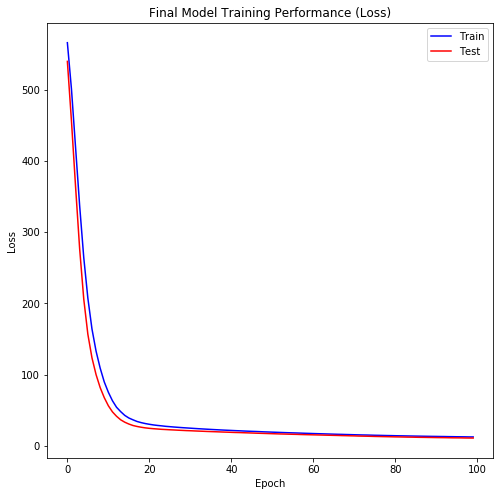

In [45]:
# Summarize model training hisotry for accuracy and loss
fig, axs = plt.subplots(1, 1, figsize=(8,8))
plt.subplot(111)
plt.plot(final_hist.history['loss'], color='blue', label='train')
plt.plot(final_hist.history['val_loss'], color='red', label='test')
plt.title('Final Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [46]:
# Evaluate the Keras model on previously unseen data
scores = final_model.evaluate(X_test, y_test)
print("Final MSE of the model: %f" % (scores))
print("Final RMSE of the model: %f" % (math.sqrt(scores)))

127/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [47]:
if (notifyStatus): email_notify("Phase 4 Optimize Model completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Section 5. Finalize Model

In [48]:
if (notifyStatus): email_notify("Phase 5 Finalize Model has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [49]:
# Make class predictions with the model
predictions = final_model.predict(X_test)

# Summarize the first 20 cases
for i in range(20):
	print('Data item #%d predicted to be %.2f (expected %.2f)' % (i, predictions[i], y_test[i]))

Data item #0 predicted to be 21.16 (expected 22.40)
Data item #1 predicted to be 31.50 (expected 32.40)
Data item #2 predicted to be 19.03 (expected 21.70)
Data item #3 predicted to be 17.56 (expected 24.50)
Data item #4 predicted to be 24.60 (expected 16.80)
Data item #5 predicted to be 21.15 (expected 21.10)
Data item #6 predicted to be 29.97 (expected 29.40)
Data item #7 predicted to be 26.46 (expected 28.70)
Data item #8 predicted to be 22.80 (expected 21.50)
Data item #9 predicted to be 13.62 (expected 13.60)
Data item #10 predicted to be 20.33 (expected 21.40)
Data item #11 predicted to be 25.11 (expected 24.80)
Data item #12 predicted to be 17.54 (expected 16.80)
Data item #13 predicted to be 22.36 (expected 19.40)
Data item #14 predicted to be 21.59 (expected 21.70)
Data item #15 predicted to be 12.99 (expected 17.20)
Data item #16 predicted to be 13.23 (expected 17.10)
Data item #17 predicted to be 20.33 (expected 18.70)
Data item #18 predicted to be 23.33 (expected 22.30)
Dat

In [50]:
if (notifyStatus): email_notify("Phase 5 Finalize Model completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [51]:
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 0:04:24.385900
